In [49]:
#Install
!pip install -U scikit-learn

In [ ]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
#Download file
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [ ]:
#Buat dataframe
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

#Buat kolom baru
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffLogPassengers'] = df['LogPassengers'].diff()

#Buat variable baru untuk data training dan testing
Ntest = 12
train = df.iloc[:-Ntest] # data < tail(12)
test = df.iloc[-Ntest:] # data = tail(12)

#Buat supervised dataset
#Mari lihat apakah kita dapat menggunakan nilai T-past untuk memprediksi nilai selanjutnya 
series = df['DiffLogPassengers'].to_numpy()[1:]

#Buat variable dan array
T = 10
X = []
Y = []

#Buat perulangan untuk mengisi array X dan Y
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

#Ubah menjadi ndarray dan lakukan reshape
X = np.array(X).reshape(-1, T)
Y = np.array(Y)

#Hitung banyaknya data dari array X
N = len(X)

#Display
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [ ]:
#Buat variable untuk data training dan testing
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

# Linear Regression

In [ ]:
#Buat model
lr = LinearRegression()

#Fit model
lr.fit(Xtrain, Ytrain)

#Display score dari model
print("Score model LR:", lr.score(Xtrain, Ytrain))

Score model LR: 0.6837135048453121


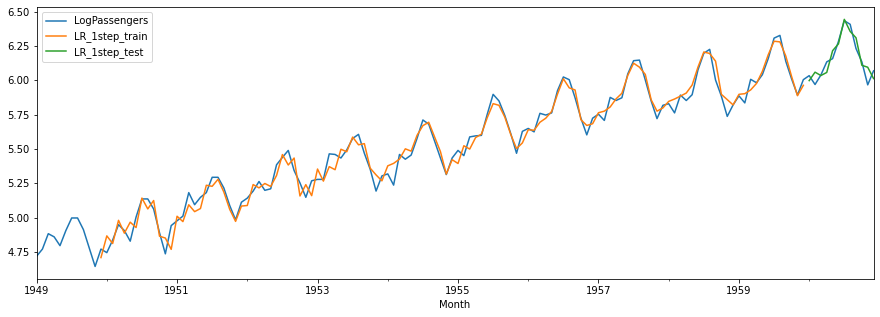

In [ ]:
#Boolean index
#Buat variable
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # nilai T pertama tidak dapat diprediksi

#Dibutuhkan untuk menghitung prediksi yang tidak berbeda
#1.Buat kolom baru
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1) # => shift adalah fungsi untuk menggeser posisi sesuai yang kita inginkan
#2.Buat variable baru
prev = df['ShiftLogPassengers']

#Buat variable untuk menampung nilai terakhir di data training
last_train = train.iloc[-1]['LogPassengers']

#1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

#Plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

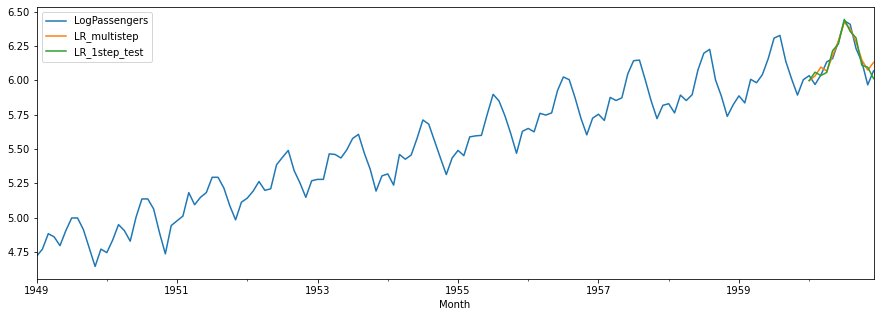

In [ ]:
#Multi-step forecast
multistep_predictions = []

#Buat variable untuk input nilai pertama data testing
last_x = Xtest[0]

#Buat perulangan
while len(multistep_predictions) < Ntest:
  #Buat variable
  p = lr.predict(last_x.reshape(1, -1))[0]
  
  #Update predictions list
  multistep_predictions.append(p)
  
  #Buat input baru
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

#Simpan multi-step forecast ke dalam dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

#Plot 1-step and multi-step forecast
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [ ]:
#Buat multi-output supervised dataset

#Buat variable
Tx = T
Ty = Ntest

#Buat array
X = []
Y = []

#Buat perulangan
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

#Ubah data menjadi ndarray dan reshape
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

#Buat variable untuk mengetahui jumlah data array X
N = len(X)

#Display
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [ ]:
#Buat variable untuk data training dan testing
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

#Buat model
lr = LinearRegression()

#Fit model
lr.fit(Xtrain_m, Ytrain_m)

#Score model
print("Score model LR:", lr.score(Xtrain_m, Ytrain_m))

Score model LR: 0.8141637147930583


In [ ]:
#Hitung R2
print("Score R2:", r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten()))

Score R2: 0.7690077978619654


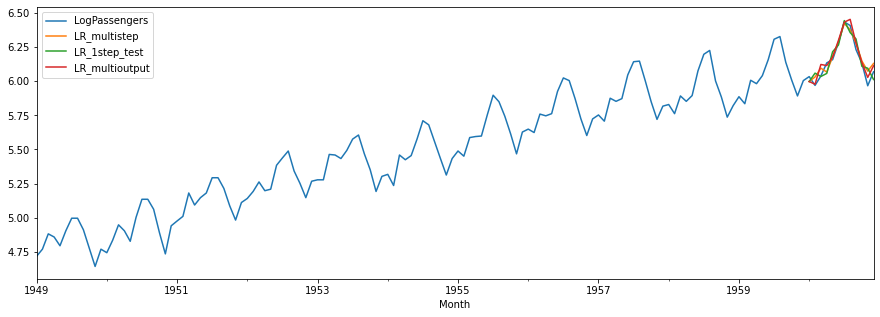

In [ ]:
#Simpan multi-output forecast ke dalam dataframe
df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest_m).flatten())

#Plot semua forecasts
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.007109281288502525
multi-output MAPE: 0.005245261617574867


# Tes model lainnya

In [ ]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = \
    prev[train_idx] + model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = \
    prev[test_idx] + model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = \
    last_train + np.cumsum(multistep_predictions)

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.012149122102392764


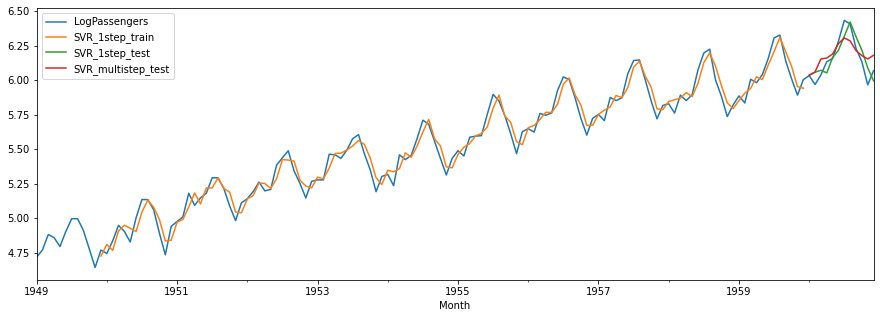

In [ ]:
#Tes fungsi dengan SVR
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.005689814916332309


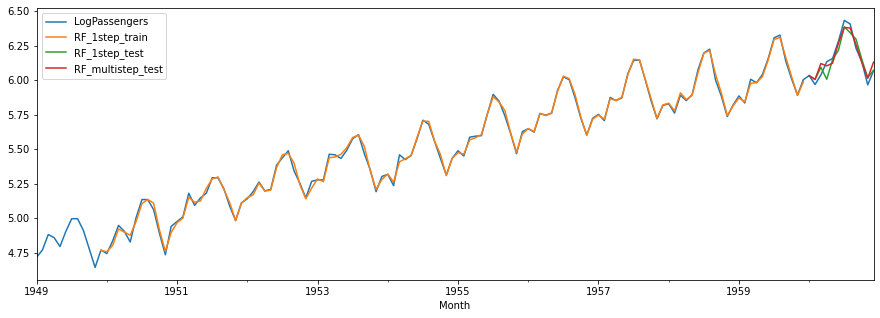

In [ ]:
#Tes fungsi dengan RandomForest
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [ ]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)
  
  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = \
    last_train + np.cumsum(model.predict(Xtest_m).flatten())
  
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [48]:
# multi_output_forecast(SVR(), "SVR") # tidak bisa handle multi-output!

In [ ]:
class SVRWrapper:
  def __init__(self, h, **args):
    self.h = h
    self.models = [SVR(**args) for _ in range(h)]
  
  def fit(self, X, Y):
    for k in range(self.h):
      self.models[k].fit(X, Y[:, k])
  
  def predict(self, X):
    P = [m.predict(X) for m in self.models]
    return np.hstack(P)


Test MAPE (multi-output): 0.010731361803536803


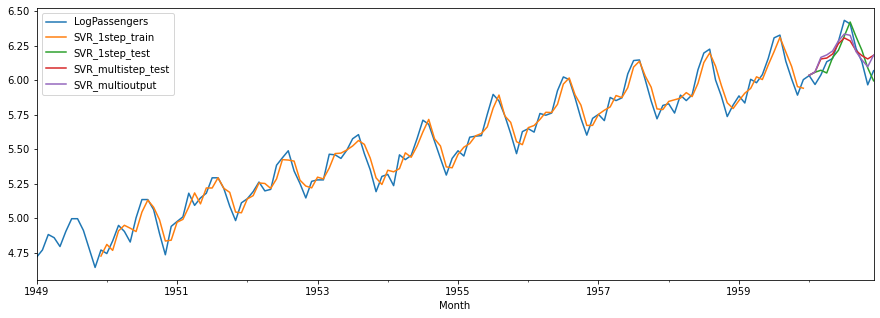

In [ ]:
multi_output_forecast(SVRWrapper(Ntest), "SVR")

Test MAPE (multi-output): 0.004722027366788373


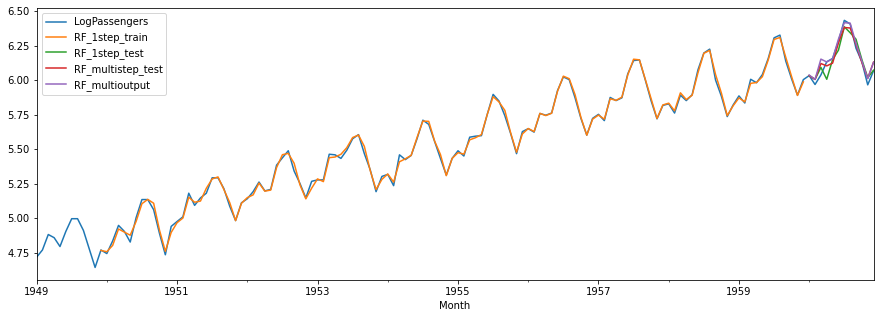

In [ ]:
multi_output_forecast(RandomForestRegressor(), "RF")